<a href="https://colab.research.google.com/github/11vedant/BharatIntern_AI/blob/main/diabetic_retinopathy_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**How to Use:**
1. go to kaggle, sign in
2. go to profile, then account
3. create new key
4. run the cell below and upload the kaggle.json file

In [ ]:
from os.path import exists

if not exists('/content/dataset/'):
  if not exists('/content/kaggle.json'):
    from google.colab import files
    files.upload()
    ! mkdir ~/.kaggle
    ! cp kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json
  # ! kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-2019-data
  ! kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered
  # ! unzip -qo diabetic-retinopathy-224x224-2019-data.zip
  ! unzip -qo diabetic-retinopathy-224x224-gaussian-filtered.zip

  ! mv gaussian_filtered_images/gaussian_filtered_images dataset
  # ! mv colored_images dataset
else:
  print("Dataset Found.")

In [ ]:
#@title Importing Required Libraries, Classes, Functions

import numpy as np
from pandas import DataFrame
from matplotlib import pyplot as plt
from keras.utils import image_dataset_from_directory
from keras import layers
from tensorflow import image as filter
from tensorflow import data
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.applications import InceptionV3
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import CategoricalAccuracy
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from tqdm.keras import TqdmCallback
from keras.utils import split_dataset

In [ ]:
#@title Importing dataset, splitting it it.
train_ds, test_valid_ds = image_dataset_from_directory(
    '/content/dataset',
    image_size = (225,225),
    subset='both',
    seed=1,
    validation_split = 0.3,
    batch_size=32,
    label_mode='categorical',
)
test_ds, val_ds = split_dataset(test_valid_ds, left_size=0.5)
print(f"Approximate Split : train - {len(train_ds)*32}, test - {len(test_ds)*32}, valid - {len(val_ds)*32}")

NameError: ignored

In [ ]:
#@title For Optimizations (caching)
AUTOTUNE = data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

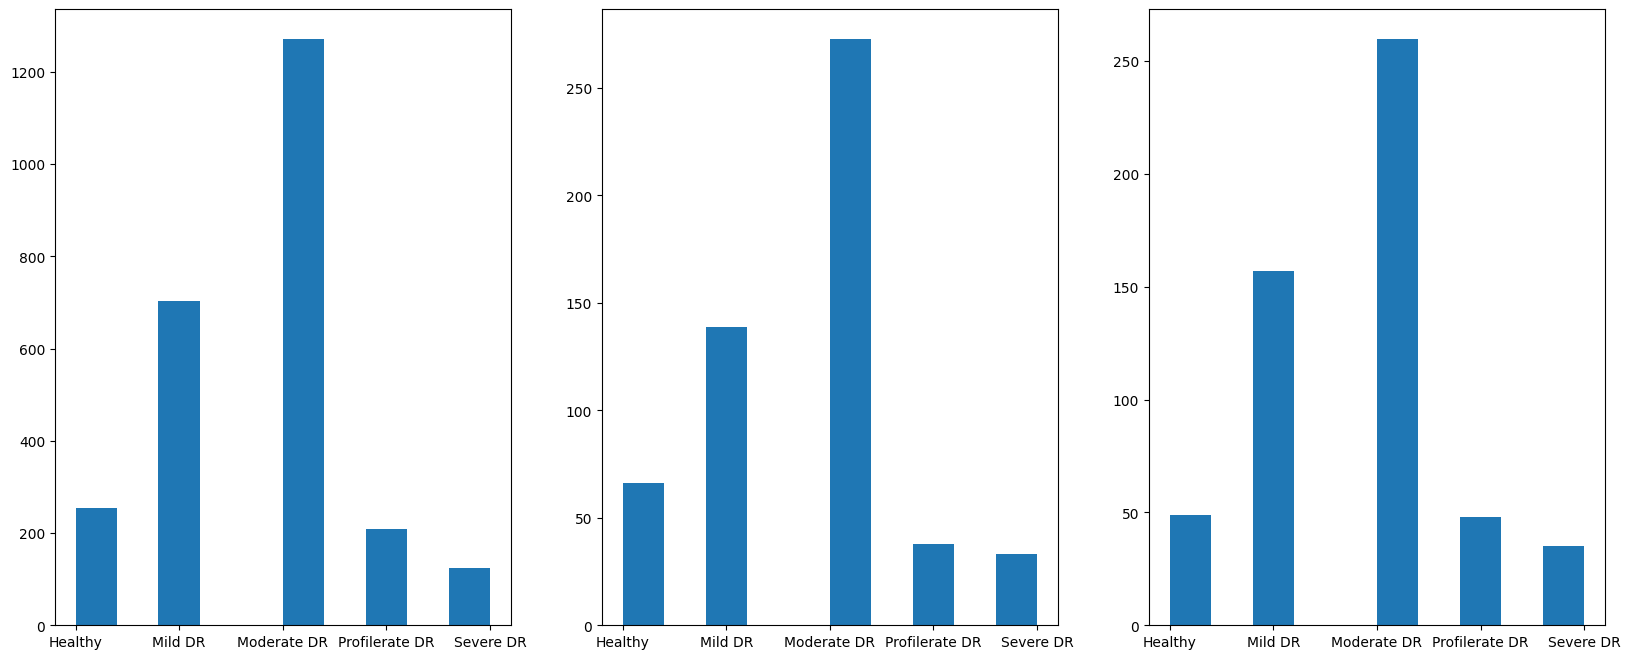

In [ ]:
#@title Dataset Class Count - Vizualization
get_labels = lambda ds : DataFrame(np.concatenate([np.argmax(y,axis=-1) for x, y in ds])).replace({0:'Healthy',1:'Mild DR',2:'Moderate DR',3:'Profilerate DR',4:'Severe DR'}).sort_values(0)
plt.figure(figsize=(20, 8))
plt.subplot(1,3,1)
plt.hist(get_labels(train_ds))
plt.subplot(1,3,2)
plt.hist(get_labels(test_ds))
plt.subplot(1,3,3)
plt.hist(get_labels(val_ds))
plt.show()

In [ ]:
#@title Defining Preprocessing and augmentation pipeline
preprocess = Sequential([
    layers.Resizing(225, 225),
    layers.Rescaling(1./255),
])
augment = Sequential([
    layers.RandomContrast(0.05),
    layers.RandomRotation((-0.1,0.1)),
    layers.RandomBrightness((-0.05,0.1)),
    layers.RandomZoom((-0.05,0.05)),
])



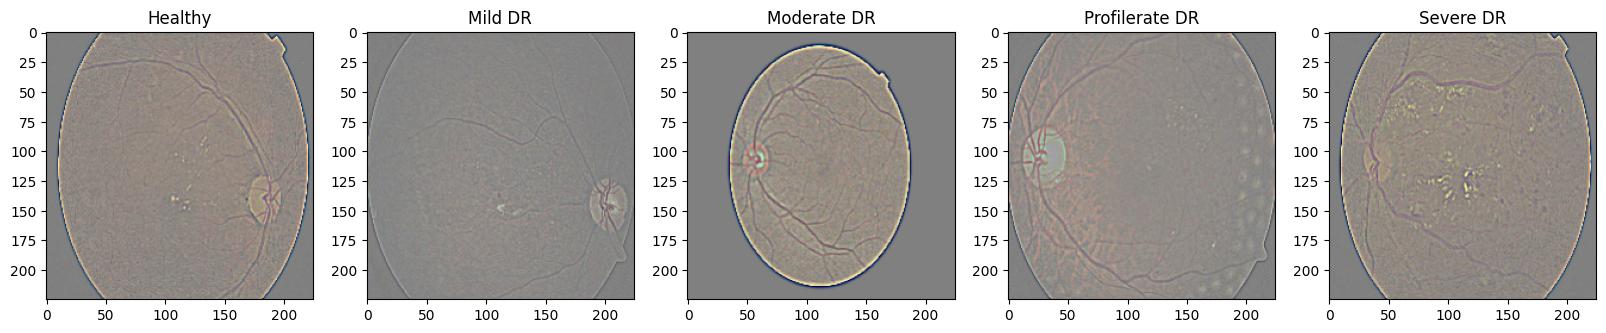

In [ ]:
#@title Vizualizing each class from dataset with preprocessing and filter
image_batch, label_batch = next(iter(test_ds))
plt.figure(figsize=(20,8))
plotted = dict()

for image, label in zip(image_batch, label_batch):
    if len(plotted)==5:
        break
    elif int(np.argmax(label,axis=-1)) in plotted.keys():
        continue
    else:
        plotted[int(np.argmax(label,axis=-1))] = image.numpy()
plotted = {i:plotted[i] for i in sorted(plotted.keys())}
for i in plotted.keys():
    plt.subplot(1,5,i+1)
    plt.imshow(preprocess((plotted[i])))
    plt.title({0:'Healthy',1:'Mild DR',2:'Moderate DR',3:'Profilerate DR',4:'Severe DR'}[i])
plt.show()

In [ ]:
#@title Applying preprocessing to entire dataset and augmentation to train dataset
train_ds = train_ds.map(lambda x, y: (augment(x), y))

train_ds = train_ds.map(lambda x, y: (preprocess(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess(x), y))
test_ds = test_ds.map(lambda x, y: (preprocess(x), y))

In [ ]:
#@title Loading pre-trained InceptionV3 model
base_model = InceptionV3(input_shape=(225,225,3),include_top=False,weights='imagenet')

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
#@title Setting up trainable layers for the model
for layer in base_model.layers: layer.trainable=False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(5,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 22,069,349
Trainable params: 266,565
Non-trainable params: 21,802,784
____________________________________

In [ ]:
#@title Compiling model and defining callbacks
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=[CategoricalAccuracy(name='accuracy')])
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor="val_accuracy",mode="max", verbose=1, patience=2)


In [ ]:
#@title Fitting Model
history = model.fit(train_ds, epochs=8, validation_data=test_ds ,callbacks=[checkpointer, earlystopping], verbose=1 , shuffle=True)

Epoch 1/8
80/81 [============================>.] - ETA: 0s - loss: 0.6628 - accuracy: 0.7543
Epoch 1: val_loss improved from 0.72005 to 0.67903, saving model to weights.hdf5
81/81 [==============================] - 32s 394ms/step - loss: 0.6626 - accuracy: 0.7543 - val_loss: 0.6790 - val_accuracy: 0.7395
Epoch 2/8
80/81 [============================>.] - ETA: 0s - loss: 0.6497 - accuracy: 0.7609
Epoch 2: val_loss did not improve from 0.67903
81/81 [==============================] - 31s 382ms/step - loss: 0.6494 - accuracy: 0.7609 - val_loss: 0.6813 - val_accuracy: 0.7341
Epoch 3/8
80/81 [============================>.] - ETA: 0s - loss: 0.6505 - accuracy: 0.7586
Epoch 3: val_loss improved from 0.67903 to 0.67800, saving model to weights.hdf5
81/81 [==============================] - 32s 397ms/step - loss: 0.6501 - accuracy: 0.7586 - val_loss: 0.6780 - val_accuracy: 0.7450
Epoch 4/8
80/81 [============================>.] - ETA: 0s - loss: 0.6333 - accuracy: 0.7641
Epoch 4: val_loss did n

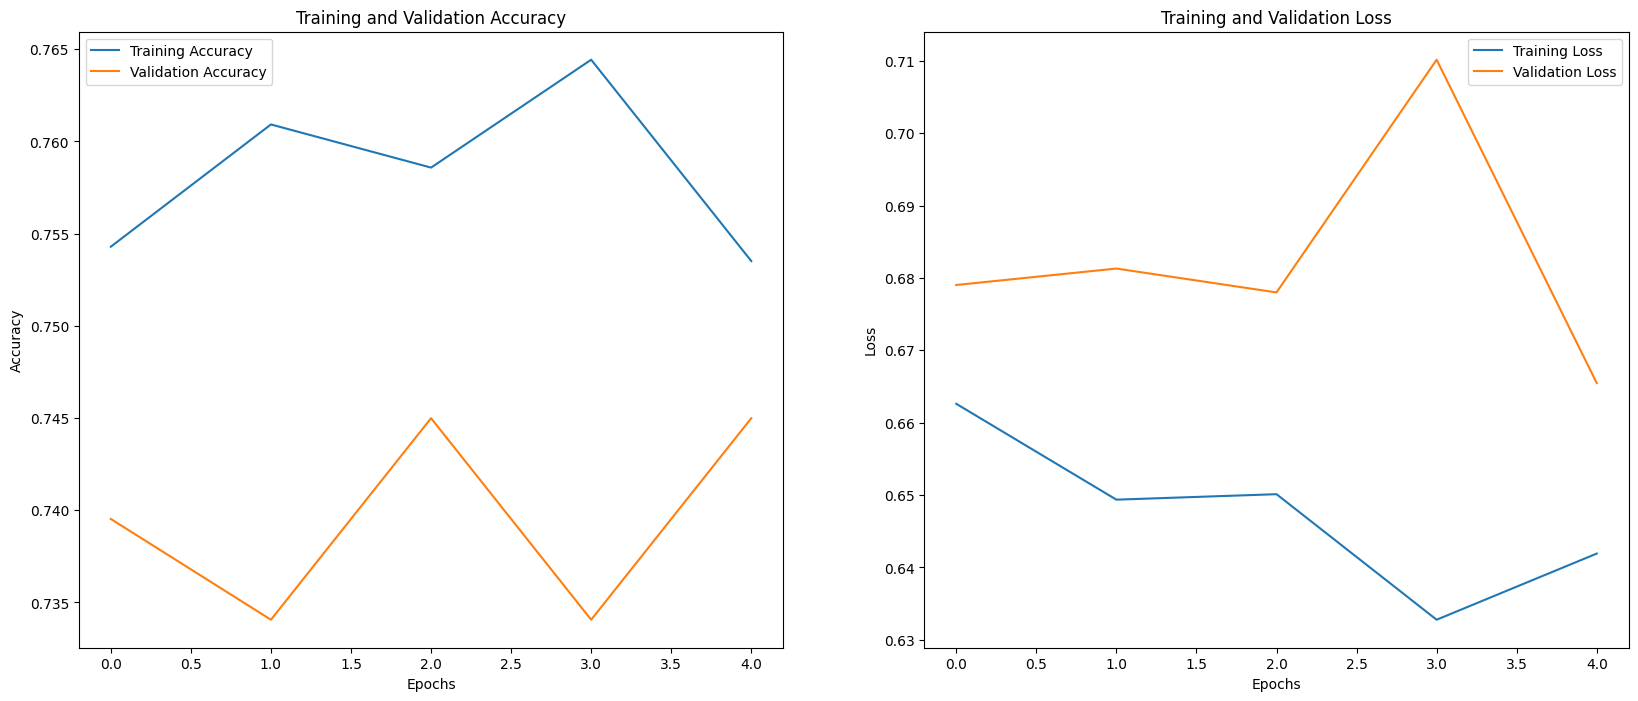

In [ ]:
#@title plotting results
acc, val_acc = history.history['accuracy'],  history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs_range = range(len(history.history['accuracy']))
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout
plt.show()

18/18 [==============================] - 1s 69ms/step
              precision    recall  f1-score   support

           0       0.59      0.27      0.37        49
           1       0.60      0.78      0.68       157
           2       0.82      0.99      0.90       260
           3       0.43      0.06      0.11        48
           4       0.50      0.03      0.05        35

    accuracy                           0.72       549
   macro avg       0.59      0.43      0.42       549
weighted avg       0.68      0.72      0.66       549



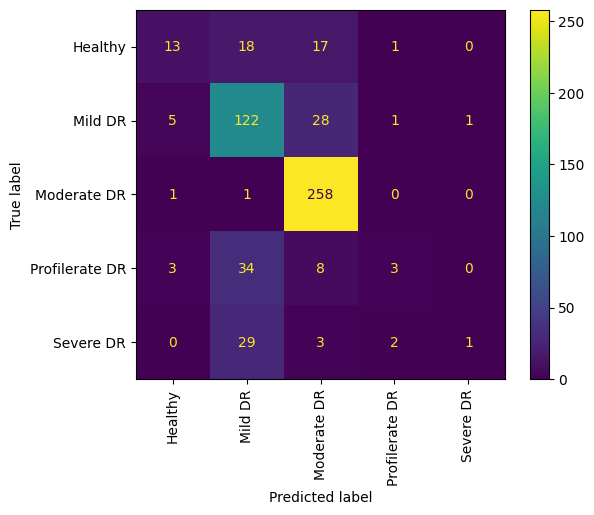

In [ ]:
#@title confusion matrix
y_pred = model.predict(val_ds)

y_pred = [np.argmax(x,axis=-1) for x in y_pred]
y_true = np.concatenate([np.argmax(y,axis=-1) for x, y in val_ds])

ConfusionMatrixDisplay.from_predictions(
    y_true
    ,y_pred
    ,display_labels=['Healthy','Mild DR','Moderate DR','Profilerate DR','Severe DR']
    ,xticks_rotation="vertical")

print(classification_report(y_true, y_pred))

In [ ]:
res = model.evaluate(val_ds,verbose=0)
print("Accuracy : ",res[1]*100)

Accuracy :  72.31329679489136
